In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
opener = urllib.request.build_opener()
urllib.request.install_opener(opener)

# Access the datasets from torchvision
training_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True, padding_mode='reflect')
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(in_features=7*7*32, out_features=10, bias=True)
    self.flatten = nn.Flatten()
    self.sm = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.maxpool(self.conv1(x))
    x = F.relu(x)
    x = self.maxpool(self.conv2(x))
    x = F.relu(x)
    x = F.relu(self.conv3(x))
    x = self.flatten(x)
    x = self.fc1(x)
    return self.sm(x)

In [4]:
def accuracy(predictions, Y):
    return (predictions.argmax(dim=1) == Y).float().mean()

In [5]:
def plot_cost_iteration(training_loss, test_loss, epochs):
    plt.plot(np.arange(start=0, stop=epochs, step= 1), training_loss, label='Training data')
    plt.plot(np.arange(start=0, stop=epochs, step= 1), test_loss, label='Test data')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost per Iteration')
    plt.legend()
    plt.show()

In [6]:
def plot_accuracy_iteration(training_accuracy, test_accuracy, epochs):
    plt.plot(np.arange(start=1, stop=epochs+1, step= 1), training_accuracy, label='Training data')
    plt.plot(np.arange(start=1, stop=epochs+1, step= 1), test_accuracy, label='Test data')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Iteration')
    plt.legend()
    plt.show()

In [7]:
def compute_confusion_matrix(predictions, true_labels):
  predictions = predictions.argmax(dim=1)
  matrix = np.zeros(shape=(10,10))
  for datapoint in range(0,len(true_labels)):
    prediction = predictions[datapoint]
    true_class = true_labels[datapoint]
    matrix[prediction,true_class] += 1
  return matrix

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch     5: train loss  1.48 train accuracy  98.24 test loss  1.48 test accuracy  98.34
Epoch    10: train loss  1.47 train accuracy  98.79 test loss  1.48 test accuracy  98.65
Epoch    15: train loss  1.47 train accuracy  98.97 test loss  1.47 test accuracy  98.83
Epoch    20: train loss  1.47 train accuracy  99.11 test loss  1.47 test accuracy  98.86
Epoch    25: train loss  1.47 train accuracy  99.16 test loss  1.47 test accuracy  98.78


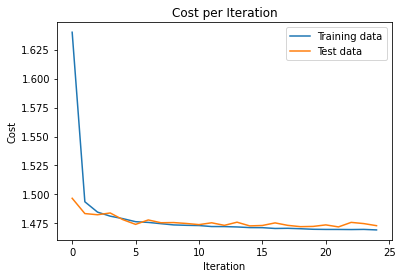

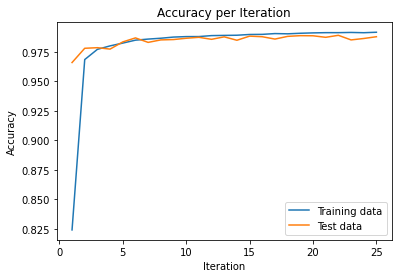

In [8]:
# Initialise hyperparameters
minibatch_size = 32
learning_rate = 0.001
epochs = 25

# Data structures to hold accuracy and loss values throughout the iterations
training_accuracy = []
training_loss = []
test_accuracy = []
test_loss = []

# Load the test dataset without shuffling
test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

cnn = ConvolutionalNeuralNetwork()
cnn.to(device)

# Use Adam optimiser
optimiser = optim.Adam(cnn.parameters(), lr=learning_rate)
loss_funtion = nn.CrossEntropyLoss()

# Training
for epoch in range(0, epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    # Load the training dataset using batches and shuffling
    train_dataLoader = torch.utils.data.DataLoader(training_dataset, batch_size=minibatch_size, shuffle=True)
    dataset_size = len(train_dataLoader.dataset)

    for (x_batch, y_batch) in train_dataLoader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimiser.zero_grad()
      predictions = cnn(x_batch) # Forward pass on training batch
      batch_accuracy = accuracy(predictions, y_batch) # Compute accuracy on training batch
      epoch_accuracy += batch_accuracy.item()
      loss = loss_funtion(predictions, y_batch) # Compute loss on training batch
      batch_loss = loss.item()
      epoch_loss += batch_loss
      loss.backward() # Back propagation
      optimiser.step() # Parameters update

    training_accuracy.append(epoch_accuracy / len(train_dataLoader))
    training_loss.append(epoch_loss / len(train_dataLoader))

    with torch.no_grad():
      for (x_test, y_test) in test_dataLoader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        predictions = cnn(x_test) # Forward pass on test dataset
        test_accuracy.append(accuracy(predictions, y_test).item()) # Compute accuracy on test dataset
        test_loss.append(loss_funtion(predictions, y_test).item()) # Compute loss on test dataset
    
    if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch+1:5d}: train loss {training_loss[-1]:5.2f} train accuracy {100*training_accuracy[-1]:6.2f} '\
            f'test loss {test_loss[-1]:5.2f} test accuracy {100*test_accuracy[-1]:6.2f}')

# Plotting
plot_cost_iteration(training_loss, test_loss, epochs)
plot_accuracy_iteration(training_accuracy, test_accuracy, epochs)

In [9]:
with torch.no_grad():
  for (x_test, y_test) in test_dataLoader:
    x_test, y_test = x_test.to(device), y_test.to(device)
    predictions = cnn(x_test) # Forward pass on test dataset
    confusion_matrix = compute_confusion_matrix(predictions, y_test)
    for row in range(0, 10):
      for col in range(0, 10):
        print(f'{int(confusion_matrix[row,col]):6d}', end = " ")
      print('\n')

   977      0      1      1      0      1      7      0      4      2 

     0   1130      0      0      0      0      3      4      0      3 

     0      2   1025      5      0      0      1     12      2      2 

     0      0      0    998      0      7      0      1      1      3 

     0      1      0      0    980      0      2      0      1     11 

     0      0      0      3      0    882      5      0      3      3 

     1      1      0      0      0      1    939      0      0      0 

     1      1      3      2      0      0      0   1009      0      6 

     1      0      3      1      0      0      1      1    961      2 

     0      0      0      0      2      1      0      1      2    977 



In [10]:
misclassification_indices = []
for (x_test, y_test) in test_dataLoader:
  x_test, y_test = x_test.to(device), y_test.to(device)
  predictions = cnn(x_test)
  predictions = predictions.argmax(dim=1)
  for datapoint in range(0,len(y_test)):
    prediction = predictions[datapoint]
    true_class = y_test[datapoint]
    if prediction != true_class:
      misclassification_indices.append(datapoint)

True label: 5
Prediction: 3
Corresponding input image:


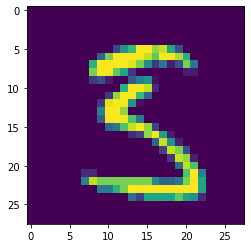

In [20]:
index = 42
print(f'True label: {y_test[misclassification_indices[index]].item()}')
print(f'Prediction: {predictions[misclassification_indices[index]].item()}')
print('Corresponding input image:')
plt.imshow(x_test[misclassification_indices[index]].cpu().squeeze())